In [22]:
#Import Required modules
from IPython.display import display, IFrame, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from generic_functions import *
#Hanlding Images
from skimage.io import imread
from imageio import imwrite
import pprint
from tqdm import tqdm
from tqdm import tnrange
import numba as nb
from sklearn.preprocessing import normalize, StandardScaler
import pylab
from scipy.stats import normaltest, shapiro, anderson, skew
import seaborn as sns
import random
import os
from os import listdir
from os.path import isfile, join
from matplotlib import gridspec
import statsmodels.api as sm
from skimage.io import imread
import glob
from scipy.stats import normaltest
import bqplot
import datetime
import time
#To Create EarthEngine Object
import ee

#Formatting Setup
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 18


pp = pprint.PrettyPrinter(depth=4)
tqdm.monitor_interval = 0

# Authenticate to the Earth Engine servers.
ee.Initialize()

<class 'Exception'>


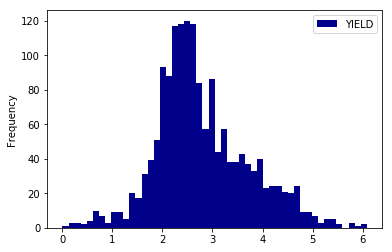

,STATE,DISTRICT
0,Andhra Pradesh,Anantapur
1,Andhra Pradesh,Chittoor
2,Andhra Pradesh,Kurnool
3,Andhra Pradesh,Prakasam
4,Andhra Pradesh,Nellore
5,Andhra Pradesh,Srikakulam
6,Andhra Pradesh,Vizianagaram
7,Assam,Barpeta
8,Assam,Bongaigaon
9,Assam,Darrang


In [24]:
#Set Base directory as Capstone path
dir_path=os.getcwd()
try: 
    os.chdir(os.getcwd()[0:dir_path.index('Code')])
except Exception:
    print(Exception)
    
# Paddy yields distribution across India between 2010 and 2016 for 5 states
paddy=pd.read_csv('Data\Yield_Data.csv')
paddy.columns=['YEAR', 'STATE', 'DISTRICT', 'YIELD', 'AREA']
#paddy=paddy[paddy['DISTRICT']=='Pilibhit']
paddy=paddy[paddy['YEAR']<2018]
paddy=paddy[paddy['YEAR']>2009]

#Show paddy distrribution
paddy[['YIELD']].plot.hist(bins=50, color='darkblue')
plt.savefig('yields distribution', dpi=500)
plt.show()
normaltest(paddy[['YIELD']].values.tolist())

#Get location to be extracted from MODIS satellite
locations=pd.read_csv('Data\locations.csv')
locations.columns=['STATE', 'DISTRICT']
#Dist = ['Pilibhit','East Godavari']
#locations= locations[locations.DISTRICT.isin(Dist)]

locations


In [25]:
# Getting district level information for Temperature and surface reflectance
#target_sat = {'MODIS/006/MOD09A1':[0,1,2,3,4,5,6]\
#             }
#folders = ['MODIS_SR' \
#          ]
target_sat = {'MODIS/006/MYD11A2':[0,4],\
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6]\
             }
folders = ['MODIS_TEMP',\
           'MODIS_SR' \
          ]


dates = ['2010-1-2', '2018-1-2']

scale  = 500   # 500m = 1 pixel
dates_of_images = {folder:[] for folder in folders}

#################################################################################################

district_region = ee.FeatureCollection('ft:1AGZC5wziTCcOJ8iu_K4UwpxjSZYlIXPYjY-e9cEh')

for folder, target in zip(folders, target_sat):

    img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + folder +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per district. (", v['percent_available'], "%)")

"""
    # Extract images
    for loc1, loc2 in locations.values:

        #im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        im_name= folder+'_'+loc1+'_'+loc2
        print (im_name)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a county
        region = district_region.filterMetadata('NAME_1', 'equals', loc1)
        region = ee.FeatureCollection(region).filterMetadata('NAME_2', 'equals', loc2)
        region = ee.Feature(region.geometry()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        #if (i%250 == 0) or (i == len(locations)-1):
        #    print(i)
"""


 ######################### MODIS_TEMP #########################
Total Dates Available:  304
Dates available:  ['2010-03-06', '2010-03-14', '2010-03-22', '2010-03-30', '2010-04-07', '2010-04-15', '2010-04-23', '2010-05-01', '2010-05-09', '2010-05-17', '2010-05-25', '2010-06-02', '2010-06-10', '2010-06-18', '2010-06-26', '2010-07-04', '2010-07-12', '2010-07-20', '2010-07-28', '2010-08-05', '2010-08-13', '2010-08-21', '2010-08-29', '2010-09-06', '2010-09-14', '2010-09-22', '2010-09-30', '2010-10-08', '2010-10-16', '2010-10-24', '2010-11-01', '2010-11-09', '2010-11-17', '2010-11-25', '2010-12-03', '2010-12-11', '2010-12-19', '2010-12-27', '2011-03-06', '2011-03-14', '2011-03-22', '2011-03-30', '2011-04-07', '2011-04-15', '2011-04-23', '2011-05-01', '2011-05-09', '2011-05-17', '2011-05-25', '2011-06-02', '2011-06-10', '2011-06-18', '2011-06-26', '2011-07-04', '2011-07-12', '2011-07-20', '2011-07-28', '2011-08-05', '2011-08-13', '2011-08-21', '2011-08-29', '2011-09-06', '2011-09-14', '2011-

Dates available:  ['2010-03-06', '2010-03-14', '2010-03-22', '2010-03-30', '2010-04-07', '2010-04-15', '2010-04-23', '2010-05-01', '2010-05-09', '2010-05-17', '2010-05-25', '2010-06-02', '2010-06-10', '2010-06-18', '2010-06-26', '2010-07-04', '2010-07-12', '2010-07-20', '2010-07-28', '2010-08-05', '2010-08-13', '2010-08-21', '2010-08-29', '2010-09-06', '2010-09-14', '2010-09-22', '2010-09-30', '2010-10-08', '2010-10-16', '2010-10-24', '2010-11-01', '2010-11-09', '2010-11-17', '2010-11-25', '2010-12-03', '2010-12-11', '2010-12-19', '2010-12-27', '2011-03-06', '2011-03-14', '2011-03-22', '2011-03-30', '2011-04-07', '2011-04-15', '2011-04-23', '2011-05-01', '2011-05-09', '2011-05-17', '2011-05-25', '2011-06-02', '2011-06-10', '2011-06-18', '2011-06-26', '2011-07-04', '2011-07-12', '2011-07-20', '2011-07-28', '2011-08-05', '2011-08-13', '2011-08-21', '2011-08-29', '2011-09-06', '2011-09-14', '2011-09-22', '2011-09-30', '2011-10-08', '2011-10-16', '2011-10-24', '2011-11-01', '2011-11-09', '

"\n    # Extract images\n    for loc1, loc2 in locations.values:\n\n        #im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n        im_name= folder+'_'+loc1+'_'+loc2\n        print (im_name)\n        scale  = scale\n        crs = 'EPSG:4326'   # Coordinate Reference System\n\n        # filter for a county\n        region = district_region.filterMetadata('NAME_1', 'equals', loc1)\n        region = ee.FeatureCollection(region).filterMetadata('NAME_2', 'equals', loc2)\n        region = ee.Feature(region.geometry()) # get the coordinates and other features\n\n        while True:\n            try:\n                export_image(img.clip(region), folder, im_name, scale, crs)\n            except Exception:\n                print(Exception)\n                time.sleep(10)\n                continue\n            break\n        #if (i%250 == 0) or (i == len(locations)-1):\n        #    print(i)\n"

In [26]:
# For moisture, the collection time is not the same as MODIS, a time interval 
#(+-4 days) of the MODIS image was created and median value of pixel was taken for the images in between the interval dates

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + 
             backward for date in dates_of_images['MODIS_SR']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE_1'
dates_of_images[folder] = date_list
scale  = 500   # 500m = 1 pixel

#################################################################################################

print('\n ######################### ' + folder +  ' #########################')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))



"""
# Extracting images
for loc1, loc2 in locations.values:

        #im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        im_name= folder+'_'+loc1+'_'+loc2
        print (im_name)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a district
        region = district_region.filterMetadata('NAME_1', 'equals', loc1)
        region = ee.FeatureCollection(region).filterMetadata('NAME_2', 'equals', loc2)
        region = ee.Feature(region.geometry()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        #if (i%500 == 0) or (i == len(locations)-1):
        #    print(i)
"""


 ######################### USDA_MOISTURE_1 #########################
Total Dates 304
There are 608 total number of images


"\n# Extracting images\nfor loc1, loc2 in locations.values:\n\n        #im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n        im_name= folder+'_'+loc1+'_'+loc2\n        print (im_name)\n        scale  = scale\n        crs = 'EPSG:4326'   # Coordinate Reference System\n\n        # filter for a district\n        region = district_region.filterMetadata('NAME_1', 'equals', loc1)\n        region = ee.FeatureCollection(region).filterMetadata('NAME_2', 'equals', loc2)\n        region = ee.Feature(region.geometry()) # get the coordinates and other features\n\n        while True:\n            try:\n                export_image(img.clip(region), folder, im_name, scale, crs)\n            except Exception:\n                print(Exception)\n                time.sleep(10)\n                continue\n            break\n        #if (i%500 == 0) or (i == len(locations)-1):\n        #    print(i)\n"

In [12]:
# Getting NDVI data for each year

target_sat = {'MODIS/006/MOD13Q1':['NDVI'] \
        }  
folders = ['MODIS_NDVI' \
           ]

#Run one by one for each dates, dowload images from google drive and name them as <image_name>_year
#dates = ['2010-1-2', '2011-1-2']
#dates = ['2011-1-2', '2012-1-2']
#dates = ['2012-1-2', '2013-1-2']
#dates = ['2013-1-2', '2014-1-2']
#dates = ['2014-1-2', '2015-1-2']
#dates = ['2015-1-2', '2016-1-2']
dates = ['2016-1-2', '2017-1-2']
#dates = ['2017-1-2', '2018-1-2']

scale  = 500   # 500m = 1 pixel
#dates_of_images = {folder:[] for folder in folders}

#################################################################################################

for folder, target in zip(folders, target_sat):

    img = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .max()

    img = ee.Image(img)
"""
    # Getting images
    for loc1, loc2 in locations.values:

        #im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        im_name= folder+'_'+loc1+'_'+loc2
        print (im_name)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a district
        region = district_region.filterMetadata('NAME_1', 'equals', loc1)
        region = ee.FeatureCollection(region).filterMetadata('NAME_2', 'equals', loc2)
        region = ee.Feature(region.geometry()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        #if (i%250 == 0) or (i == len(locations)-1):
        #    print(i)

"""

MODIS_NDVI_Andhra Pradesh_Anantapur
Done. {'id': 'OOVMHVVGL36ELSST5XD3GPXS', 'state': 'READY', 'creation_timestamp_ms': 1556481109373, 'update_timestamp_ms': 1556481109373, 'description': 'MODIS_NDVI_Andhra Pradesh_Anantapur', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Andhra Pradesh_Chittoor
Done. {'id': 'VAW47SYLJD7TGVTP5BBJ6Q27', 'state': 'READY', 'creation_timestamp_ms': 1556481117610, 'update_timestamp_ms': 1556481117610, 'description': 'MODIS_NDVI_Andhra Pradesh_Chittoor', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Andhra Pradesh_Kurnool
Done. {'id': '24GR5SP3P4S5FCEPC5CXLW3E', 'state': 'READY', 'creation_timestamp_ms': 1556481125944, 'update_timestamp_ms': 1556481125944, 'description': 'MODIS_NDVI_Andhra Pradesh_Kurnool', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Andhra Pradesh_Prakasam
Done. {'id': 'M456CFSWXAYTQWXDDGK7YJJ4', 'state': 'READY', 'creation_timestamp_ms': 1556481134262, 'update_timestamp_ms': 1556481134262, 'description': 'MODIS_NDVI_Andhra Pradesh_Prakasam', 'task_type': 

Done. {'id': 'BCJSMFIZ4NJX4FYERS7YCTXK', 'state': 'READY', 'creation_timestamp_ms': 1556481390685, 'update_timestamp_ms': 1556481390685, 'description': 'MODIS_NDVI_Chhattisgarh_Rajnandgaon', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Chhattisgarh_Surguja
Done. {'id': '2AHY5N4HCUJKAKXEULAPLSYY', 'state': 'READY', 'creation_timestamp_ms': 1556481397488, 'update_timestamp_ms': 1556481397488, 'description': 'MODIS_NDVI_Chhattisgarh_Surguja', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Karnataka_Belgaum
Done. {'id': '5GEINI43JM4PBSLV6FHXUP3A', 'state': 'READY', 'creation_timestamp_ms': 1556481405875, 'update_timestamp_ms': 1556481405875, 'description': 'MODIS_NDVI_Karnataka_Belgaum', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Karnataka_Chamrajnagar
Done. {'id': 'BPSHIL3ZU3QCSNNOALTSIAYG', 'state': 'READY', 'creation_timestamp_ms': 1556481414179, 'update_timestamp_ms': 1556481414179, 'description': 'MODIS_NDVI_Karnataka_Chamrajnagar', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Karnataka_Chikmagalur
Done.

MODIS_NDVI_Tamil Nadu_Ariyalur
Done. {'id': '6LW57AZ7PYWBVJTDND6OLBWF', 'state': 'READY', 'creation_timestamp_ms': 1556481667767, 'update_timestamp_ms': 1556481667767, 'description': 'MODIS_NDVI_Tamil Nadu_Ariyalur', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Tamil Nadu_Cuddalore
Done. {'id': 'XJ7KNQRI5NO734GMNZJZAAWF', 'state': 'READY', 'creation_timestamp_ms': 1556481676031, 'update_timestamp_ms': 1556481676031, 'description': 'MODIS_NDVI_Tamil Nadu_Cuddalore', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Tamil Nadu_Dharmapuri
Done. {'id': 'GPE55633BP6N34KLVJHNGSVJ', 'state': 'READY', 'creation_timestamp_ms': 1556481684255, 'update_timestamp_ms': 1556481684255, 'description': 'MODIS_NDVI_Tamil Nadu_Dharmapuri', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Tamil Nadu_Erode
Done. {'id': 'NG4AFQHHTDH6GMCHPUQAQ544', 'state': 'READY', 'creation_timestamp_ms': 1556481692434, 'update_timestamp_ms': 1556481692434, 'description': 'MODIS_NDVI_Tamil Nadu_Erode', 'task_type': 'EXPORT_IMAGE'}
MODIS_NDVI_Tamil

KeyboardInterrupt: 

In [14]:
#Rename NDVI Files

import os 
#year = ['2010','2011','2012','2013','2014','2015','2016','2017']
#year = '2013'
#year = '2014'
#year = '2015'
year = ['2016']
#year = '2017'

for i in year:
    MODIS_NDVI_path='Data/Satellite/MODIS_NDVI/MODIS_NDVI' + '_' + i + '/'
    for filename in os.listdir(MODIS_NDVI_path): 
        src =MODIS_NDVI_path + filename
        end = filename.find('.tif') 
        fn=filename[0:end]
        
        dst =MODIS_NDVI_path + fn + '_' + i + '.tif'
        os.rename(src, dst) 

In [19]:
dates_of_images

{'MODIS_TEMP': ['2010-03-06',
  '2010-03-14',
  '2010-03-22',
  '2010-03-30',
  '2010-04-07',
  '2010-04-15',
  '2010-04-23',
  '2010-05-01',
  '2010-05-09',
  '2010-05-17',
  '2010-05-25',
  '2010-06-02',
  '2010-06-10',
  '2010-06-18',
  '2010-06-26',
  '2010-07-04',
  '2010-07-12',
  '2010-07-20',
  '2010-07-28',
  '2010-08-05',
  '2010-08-13',
  '2010-08-21',
  '2010-08-29',
  '2010-09-06',
  '2010-09-14',
  '2010-09-22',
  '2010-09-30',
  '2010-10-08',
  '2010-10-16',
  '2010-10-24',
  '2010-11-01',
  '2010-11-09',
  '2010-11-17',
  '2010-11-25',
  '2010-12-03',
  '2010-12-11',
  '2010-12-19',
  '2010-12-27',
  '2011-03-06',
  '2011-03-14',
  '2011-03-22',
  '2011-03-30',
  '2011-04-07',
  '2011-04-15',
  '2011-04-23',
  '2011-05-01',
  '2011-05-09',
  '2011-05-17',
  '2011-05-25',
  '2011-06-02',
  '2011-06-10',
  '2011-06-18',
  '2011-06-26',
  '2011-07-04',
  '2011-07-12',
  '2011-07-20',
  '2011-07-28',
  '2011-08-05',
  '2011-08-13',
  '2011-08-21',
  '2011-08-29',
  '2011-09

In [27]:
# Check number of files in each folder
USDA_MOISTURE_path = 'Data/Satellite/USDA_MOISTURE/'
MODIS_TEMP_path = 'Data/Satellite/MODIS_TEMP/'
MODIS_SR_path = 'Data/Satellite/MODIS_SR/'
MODIS_NDVI_path = 'Data/Satellite/MODIS_NDVI/'

folder_list = [USDA_MOISTURE_path, MODIS_TEMP_path, MODIS_SR_path, MODIS_NDVI_path]

USDA_MOISTURE = [f for f in listdir(USDA_MOISTURE_path) if isfile(join(USDA_MOISTURE_path, f))]
MODIS_TEMP = [f for f in listdir(MODIS_TEMP_path) if isfile(join(MODIS_TEMP_path, f))]
MODIS_SR = [f for f in listdir(MODIS_SR_path) if isfile(join(MODIS_SR_path, f))]
MODIS_NDVI = [f for f in listdir(MODIS_NDVI_path) if isfile(join(MODIS_NDVI_path, f))]

MODIS_TEMP_fips = sorted([file[11:-4] for file in MODIS_TEMP if file[0:10] == 'MODIS_TEMP'])
USDA_MOISTURE_fips = sorted([file[11:-4] for file in USDA_MOISTURE])
MODIS_SR_fips = sorted([file[11:-4] for file in MODIS_SR if file[0:10] == 'MODIS_SR'])
MODIS_NDVI_fips = sorted([file[11:-4] for file in MODIS_NDVI if file[0:10] == 'MODIS_NDVI'])

for folder in folder_list:
    seen = set()
    uniq = [x for x in USDA_MOISTURE_fips if x not in seen and not seen.add(x)]
    print('For folder {}, there are {} files in it.'.format(folder, len(uniq)))

For folder Data/Satellite/USDA_MOISTURE/, there are 176 files in it.
For folder Data/Satellite/MODIS_TEMP/, there are 176 files in it.
For folder Data/Satellite/MODIS_SR/, there are 176 files in it.
For folder Data/Satellite/MODIS_NDVI/, there are 176 files in it.


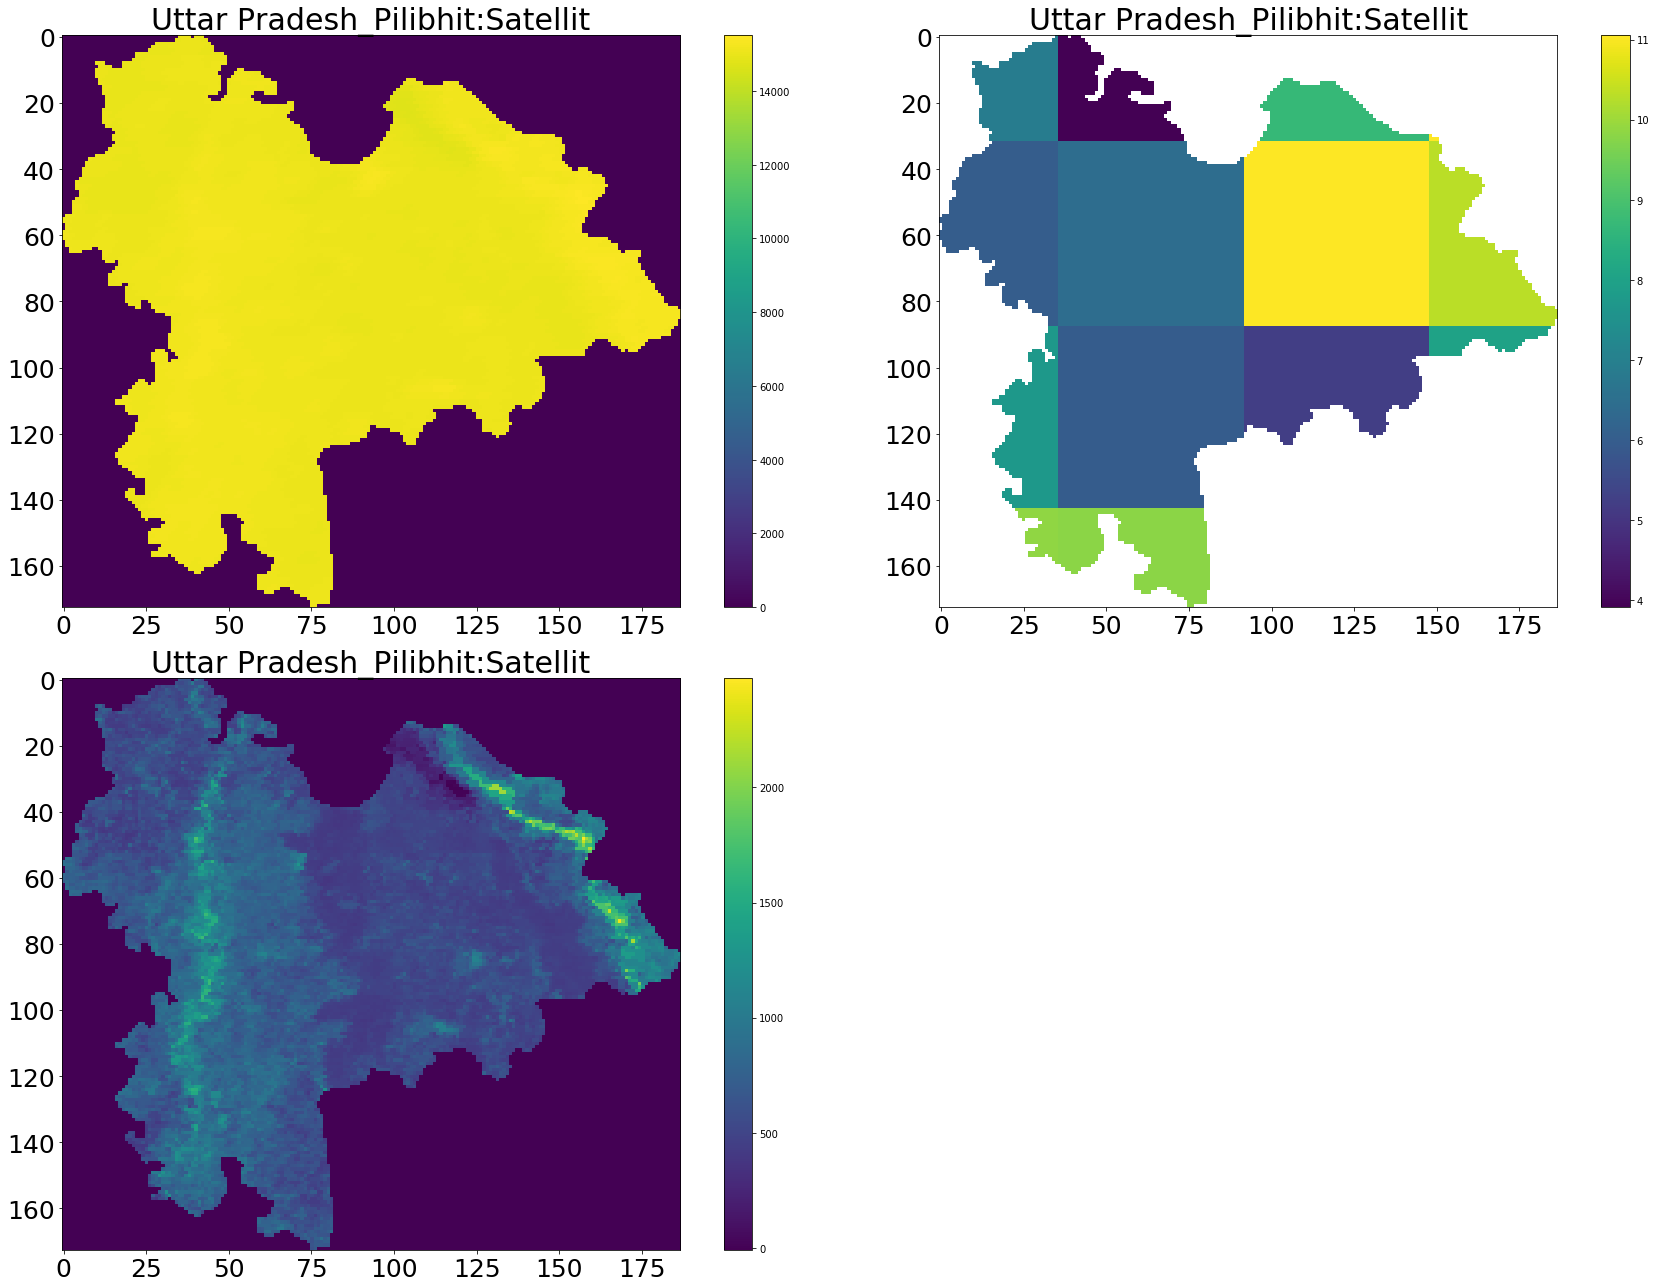

In [11]:
# Example Images
#test_county = 'Uttar Pradesh_Auraiya'
test_county = 'Uttar Pradesh_Pilibhit'
#test_county = 'Uttar Pradesh_Kannauj'
#test_county = 'Uttar Pradesh_Kanpur Dehat'

import os
#os.chdir(r"C:\Users\Janardhan\Downloads\Capstone Final\Vinayak_Py_Code\Capstone")
#path = ['Data/Satellite/MODIS_NDVI/MODIS_NDVI_', 'Data/Satellite/MODIS_TEMP/MODIS_TEMP_', 'Data/Satellite/USDA_MOISTURE/USDA_MOISTURE_',\
 #       'Data/Satellite/MODIS_SR/MODIS_SR_']
    
    
path = ['Data/Satellite/MODIS_TEMP/MODIS_TEMP_', 'Data/Satellite/USDA_MOISTURE/USDA_MOISTURE_',\
        'Data/Satellite/MODIS_SR/MODIS_SR_']    
plt.figure(figsize=(25,18))
for i, file in enumerate(path):
    test = imread(file + test_county + '.tif')
    plt.subplot(2, 2, i+1) 
    plt.imshow(test[:, :, 0])
    plt.title(test_county+':' + file.split('/')[1][:-1], fontsize=30)
    plt.colorbar()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
plt.savefig('Example Images', dpi=500)
plt.tight_layout()
plt.show()

In [28]:
def create_mask(path,folder,state,district,start_year,num_year):
    year_list=list(range(start_year, start_year + num_year, 1))
    
    imname_mask = folder + '_' + str(state) + '_' + str(district) + '_' + str(start_year) +'.tif'
    mask = imread(path + folder + '/' + imname_mask)   
    m = mask.shape[0]
    n = mask.shape[1]
    merged_arr = np.empty((m,n,num_year))
        
    for i,year in enumerate(year_list):
        imname_mask = folder + '_' + str(state) + '_' + str(district) + '_' + str(year) +'.tif'
        mask = imread(path + folder + '/' + imname_mask)
        mask[mask<=7999]=0
        mask[mask>7999]=1
        merged_arr[:, :, i ] = mask[:, :]
        
    return merged_arr
    

In [32]:
#Applying NDVI Mask

def image_processing_I(filedata):
    path, folder, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, district in tqdm(fips_data.values):
        # Create path
        #imname_mask = folder[0] + '_' + str(state) + '_' + str(distrcit) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(district) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(district) + '.tif'
        imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(district) + '.tif'

        # Reading figures
        #mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        img_3 = imread(path + folder[3] + '/' + imname_folder_3)

        # Lets do just 2010-2016 first
        #mask, new_dates[folder[0]] = filter_year(['2010', '2017'], mask, nband[0], dates_of_images[folder[0]])
        #img_1, new_dates[folder[0]] = filter_year(['2010', '2017'], img_1, nband[1], dates_of_images[folder[1]])
        img_1, new_dates[folder[1]] = filter_year(['2010', '2018'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2010', '2018'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
        or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        img_3 = zero_fill(img_3)

        if count_img_nan(img_3) > 0:
            print('The number of NaN in MODIS_SR, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
            in {} state and {} district'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
                                               state, district))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
        img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])
        
        start_year=2010
        num_year=8
        #print (start_year,num_year)
        mask=create_mask(path,folder[0],state,district,start_year,num_year)
        #print (mask.shape)
        # Masking
        
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_3_list):
            for j in range(img_year.shape[2]):
                img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
        year_list = list(range(2010, 2018))
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(district), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(district), img_year) 
        for i, img_year in enumerate(img_3_list):
            np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(district), img_year) 
            
if __name__ == "__main__":
    path = 'Data/Satellite/'
    folder = ['MODIS_NDVI', 'MODIS_SR', 'MODIS_TEMP', 'USDA_MOISTURE']
    nband = [1, 7, 2, 2]
    output_path = 'Data//'
    fips_data =locations
    filedata = path, folder, nband, fips_data, dates_of_images
    
    image_processing_I(filedata)

100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [31:12<00:00,  7.09s/it]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 101.88it/s]
C:\Users\Vinayak\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Vinayak\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Vinayak\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Vinayak\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warn

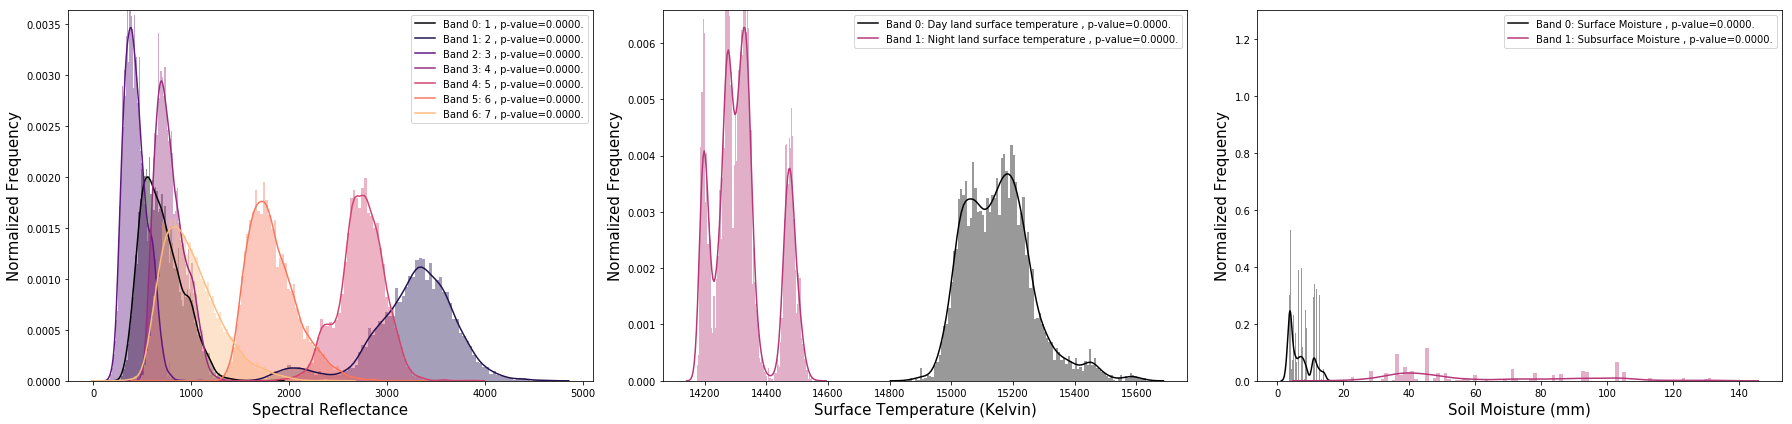

In [17]:
# Plotting distribution of band values in 25 images

plt_MODIS_SR = plt_img_dist('Data//MODIS_SR//', 7, 7, paddy)
plt_MODIS_TEMP = plt_img_dist('Data//MODIS_TEMP//', 2, 7, paddy)
plt_USDA_MOISTURE = plt_img_dist('Data//USDA_MOISTURE//', 2, 7, paddy)

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_SR': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature'],
             'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
nband = [7, 2, 2]
plt_files = [plt_MODIS_SR, plt_MODIS_TEMP, plt_USDA_MOISTURE]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)', 'Soil Moisture (mm)']

f, axs = plt.subplots(1, 3, figsize=(25,6))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nband[i]):
        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
    axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
plt.tight_layout()
plt.savefig('band distribution', dpi=500)
plt.show()

In [18]:
# Getting average values of each band in a year and other stats

def get_stats(file_dir, nband, nsample, yield_dataframe):
    
    import random

    avg_MODIS_LAND = {band:[] for band in range(0, nband)}  # average per images (38 images per year for MODIS)
    std_MODIS_LAND = {band:[] for band in range(0, nband)}
    count_MODIS_LAND = {band:[] for band in range(0, nband)}
    
    avg_year = {band:[] for band in range(0, nband)}   # yearly average (for plotting)
    var_year = {band:[] for band in range(0, nband)}
    max_year = {band:[] for band in range(0, nband)}
    count_year = {band:[] for band in range(0, nband)}
    
    avg_total = {band:[] for band in range(0, nband)}     # Total average (for statistical analysis)
    std_total = {band:[] for band in range(0, nband)} 
    
    yield_ = []
    nband = nband
    nsample = nsample

    fips = yield_dataframe[['YEAR', 'STATE', 'DISTRICT']][yield_dataframe['YEAR'] >= 2010].values
    rand_idx = random.sample(range(0, len(fips)), nsample)
    for i, _ in enumerate(fips[rand_idx]):
        #try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            yield_ += [yield_dataframe['YIELD'][(yield_dataframe['STATE'] == str(fips[i][1])) \
                                          & (yield_dataframe['DISTRICT'] == str(fips[i][2])) \
                                          & (yield_dataframe['YEAR'] == int(fips[i][0]))].values]
            for band in range(nband):
                bands = list(np.arange(band, test.shape[2], nband)) 
                non_zero_index = test[:, :, bands].nonzero()
                count_year[band] += [len(non_zero_index[0])]
                avg_year[band] += [test[:, :, bands][non_zero_index].mean()]
                var_year[band] += [test[:, :, bands][non_zero_index].var()]
                max_year[band] += [test[:, :, bands].max()]

        #except:
        #    pass

    for band in range(nband):
        # Delete NaN (i.e. samples that do not have any corn in that year)
        nan_idx = np.argwhere(np.isnan(avg_year[band]))
        avg_year[band] = np.delete(avg_year[band], nan_idx)
        var_year[band] = np.delete(var_year[band], nan_idx)
        count_year[band] = np.delete(count_year[band], nan_idx)
        

        avg_total[band] = np.sum(avg_year[band]*np.array(count_year[band]))/ np.sum(count_year[band])
        std_total[band] = np.sqrt(np.sum(var_year[band]*np.array(count_year[band]))/ np.sum(count_year[band]))
        
    yield_ = np.delete(yield_, nan_idx)       
    return avg_year, count_year, max_year, yield_, avg_total, std_total


nsample = 7

avg_year_SR, count_year_SR, max_year_SR, yield_SR, avg_total_SR, std_total_SR = \
get_stats('Data//MODIS_SR//', 7, nsample, paddy)

avg_year_TEMP, count_year_TEMP, max_year_TEMP, yield_TEMP, avg_total_TEMP, std_total_TEMP =\
get_stats('Data//MODIS_TEMP//', 2, nsample, paddy)

avg_year_MOISTURE, count_year_MOISTURE, max_year_MOISTURE, yield_MOISTURE, avg_total_MOISTURE, std_total_MOISTURE =\
get_stats('Data//USDA_MOISTURE//', 2, nsample, paddy)

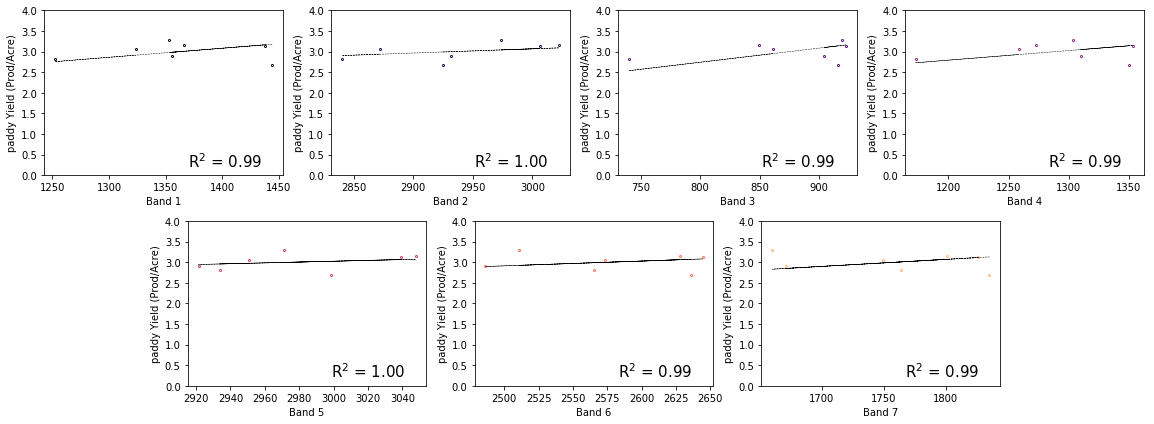

In [19]:
# Plotting correlations

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :4])
ax21 = fig.add_subplot(gs[0, 4:8])
ax31 = fig.add_subplot(gs[0, 8:12])
ax41 = fig.add_subplot(gs[0, 12:16])
ax12 = fig.add_subplot(gs[1, 2:6])
ax22 = fig.add_subplot(gs[1, 6:10])
ax32 = fig.add_subplot(gs[1, 10:14])

axs = [ax11, ax21, ax31, ax41, ax12, ax22, ax32]
cm = pylab.get_cmap('magma')
nband = 7

for ax, band in zip(axs, avg_year_SR):
    
    x = np.array(avg_year_SR[band])
    y = np.array(yield_SR)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel('Band ' + str(band + 1))
    ax.set_ylabel('paddy Yield (Prod/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 4])

fig.tight_layout()
plt.savefig('MODIS', dpi=500)
plt.show()

In [33]:
#Convert each image to histograms

def create_input_3D(input_dir, fips, output_dir):
    
    from tqdm import tqdm
    resolution = 256
    for fip in tqdm(fips):
        year = fip[0]
        state = fip[1]
        county = fip[2]

        img_1 = np.load(input_dir[0] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
        img_2 = np.load(input_dir[1] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
        temp=0
        temp1=0
        img_2_band1 = np.zeros((img_2.shape[0], img_2.shape[1], int(img_2.shape[2]/2)))
        img_2_band0 = np.zeros((img_2.shape[0], img_2.shape[1], int(img_2.shape[2]/2)))
        for i in range(img_2.shape[2]):
            if i % 2 ==0:
                img_2_band0[:,:,temp1]=img_2[:,:,i]
                temp+=1
            else:
                img_2_band1[:,:,temp1]=img_2[:,:,i]
                temp1+=1
        img_3 = np.load(input_dir[2] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')

        bin_MODIS_LAND = get_bin(img_1, [[0, 4000]]*4 + [[0, 5000]]*2 + [[0, 4000]], 7, resolution)
        #bin_MODIS_TEMP = get_bin(img_2, [[13500, 15250], [13000, 14250]], 2, resolution)
        bin_MODIS_TEMP = get_bin(img_2_band0, [[13500, 15250]], 1, resolution)
        
        bin_USDA_MOISTURE = get_bin(img_3, [[0, 26], [0, 200]], 2, resolution)

        bin_all = np.concatenate([bin_MODIS_LAND, bin_MODIS_TEMP, bin_USDA_MOISTURE], axis=0)

        np.save(output_dir + '//' + str(year) + '_' + str(state) + '_' + str(county), bin_all)

if __name__ == "__main__":
    
    fips = paddy[['YEAR', 'STATE', 'DISTRICT']][paddy['YEAR'] >= 2010]
    fips = fips[fips['YEAR'] < 2018]
    #fips.colnames=['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']
    #fips = fips[((fips['STATE_FIPS'] != 51) | (fips['COUNTY_FIPS'] != 131)) & \
    #           ((fips['STATE_FIPS'] != 46) | (fips['COUNTY_FIPS'] != 102))]
    fips = fips[['YEAR', 'STATE', 'DISTRICT']].values
    
    #fips.to_csv('Data/processed_fips.csv')
    np.savetxt(r'Data/processed_states.csv',fips,delimiter=',', fmt=('%d, %s, %s'),header="YEAR,STATE,DISTRICT")
    
    create_input_3D(['Data//MODIS_SR//', 
                    'Data//MODIS_TEMP//', 
                    'Data//USDA_MOISTURE//'], 
                    fips, \
                    'Data//PROCESSED')

  0%|                                                                                         | 0/1607 [00:00<?, ?it/s]C:\Users\Vinayak\Downloads\CBA\Capstone\Code\Deep Learning\generic_functions.py:284: RuntimeWarning: invalid value encountered in true_divide
  y[band, :, time] = np.array([count[i+1] for i in range(resolution)])/len(x)
100%|████████████████████████████████████████████████████████████████████████████| 1607/1607 [6:52:02<00:00,  2.10s/it]


In [36]:
processed_img = np.load("Data//PROCESSED//2010_Andhra Pradesh_Guntur.npy")
#for i in range(38):
    #print (i,'-',np.sum(np.isnan(processed_img[:,:,i])))
#17 -- 2010
#22 - 2011
#15, 17 - 2013
#24 -2015
#14 - 2016
processed_img.shape
#np.sum(np.isnan(processed_img))
processed_img[7,:,0]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [47]:
img=np.load('Data//MODIS_TEMP//2010_Andhra Pradesh_Guntur.npy')
img.shape #(10, 128, 38)
resolution=256
band=6
time=0
nband=2
#lims=[[0, 4000]]*4 + [[0, 5000]]*2 + [[0, 4000]]
lims=[[13500, 15250], [13000, 14250]]
#lims=[[0, 26], [0, 200]]
y = np.zeros((7, resolution, int(img.shape[2]/nband)))
bins = np.array(np.linspace(lims[1][0],lims[1][1],resolution))
#bins
temp=band + time*nband
x=img[:, :, temp][np.nonzero(img[:, :, temp])]
x=np.digitize(x.ravel(), bins)
len(x)
x
count=Counter(x)
count[256]
y[6, :, 0] = np.array([count[i+1] for i in range(resolution)])/len(x)
y[6, :, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [41]:
img.shape #(111, 126, 266)


(10, 128, 38)

In [8]:
# Originally we output the processed input as (nband, resolution, frame per year) per district file
# We are here now reshaping it to (frames, 1, resolution, nband)

nband = 10
resolution = 256

for file_name in tqdm(glob.glob('Data\PROCESSED/*.npy')):
    year, state, county = file_name[15:-4].split('_')
    processed_img = np.load(file_name)
    output_name = ('_').join([year, state, county])
    
    frames = processed_img.shape[2]
    new_processed_img = np.zeros((frames, 1, resolution, nband))
    for frame in range(frames):
        for band in range(nband):
            new_processed_img[frame, :, :, band] = processed_img[band, :, frame]
    np.save('Data/PROCESSED_II/' + output_name + '.npy', new_processed_img)

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 270.46it/s]


In [9]:
# The previous preprocessing NDVI mask from satellites can cause some images become all nan
#Here we are removing district images for that year with nan values

count_nonnan = 0
removed_ID = []
for filename in tqdm(glob.glob('Data/PROCESSED_II/*.npy')):
    file = np.load(filename)
    if np.sum(np.isnan(file)) == 0:
        np.save('Data/PROCESSED_II/' + filename[18:-4] + '.npy', file)
        count_nonnan += 1
    else:
        removed_ID += [filename[18:-4]]
print('The number of processed files with no nan is {} from the original of {}.'.format(count_nonnan, len(glob.glob('data/PROCESSED_II/*.npy'))))
#pickle.dump(removed_ID, open("data/removed_ID.p", "wb" ) )

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 790.40it/s]


The number of processed files with no nan is 85 from the original of 175.


In [34]:
#Input to CNNN

# Originally we output the processed input as (nband, resolution, frame per year) per district file
# We are here now reshaping it to (frames, 1, resolution, nband)

nband = 10
resolution = 256

for file_name in tqdm(glob.glob('Data\PROCESSED/*.npy')):
    year, state, county = file_name[15:-4].split('_')
    processed_img = np.load(file_name)
    output_name = ('_').join([year, state, county])
    
    frames = processed_img.shape[2]
    new_processed_img = np.zeros((frames, resolution, nband))
    for frame in range(frames):
        for band in range(nband):
            new_processed_img[frame, :, band] = processed_img[band, :, frame]
    np.save('Data/PROCESSED_IV/' + output_name + '.npy', new_processed_img)

# The previous preprocessing NDVI mask from satellites can cause some images become all nan
#Here we are removing district images for that year with nan values

count_nonnan = 0
removed_ID = []
for filename in tqdm(glob.glob('Data/PROCESSED_IV/*.npy')):
    file = np.load(filename)
    if np.sum(np.isnan(file)) == 0:
        np.save('Data/PROCESSED_IV/' + filename[18:-4] + '.npy', file)
        count_nonnan += 1
    else:
        removed_ID += [filename[18:-4]]
print('The number of processed files with no nan is {} from the original of {}.'.format(count_nonnan, len(glob.glob('data/PROCESSED/*.npy'))))
#pickle.dump(removed_ID, open("data/removed_ID.p", "wb" ) )

100%|█████████████████████████████████████████████████████████████████████████████| 1334/1334 [00:03<00:00, 346.21it/s]


The number of processed files with no nan is 577 from the original of 1334.


In [74]:
# Preparing {district_year: paddy yield} dictionary data which will be model input

# Load fips and other data
states_dist = pd.read_csv('Data/processed_states.csv')
states_dist.columns=['YEAR', 'STATE', 'DISTRICT']
states_dist.STATE=states_dist.STATE.str.strip()
states_dist.DISTRICT=states_dist.DISTRICT.str.strip()

states_dist_yields = paddy.merge(states_dist)[['YEAR', 'STATE', 'DISTRICT', 'YIELD']].astype(str)
states_dist_yields['YIELD'] = states_dist_yields['YIELD'].astype(float)
states_dist_yields['ID'] = states_dist_yields.apply(lambda row: row['YEAR'] + '_' + row['STATE'] + \
                                      '_' + row['DISTRICT'], axis=1)
# Remove the IDs with Nans
removed_ID = pd.DataFrame(removed_ID, columns=['ID'])
states_dist_yields = states_dist_yields[~states_dist_yields['ID'].isin([i[0] for i in removed_ID.values.tolist()])]

states_dist_yields = states_dist_yields.set_index('ID')
display(states_dist_yields)

print('\n' + '#'*13, 'YIELD MAPPING', '#'*13)

yield_train = states_dist_yields[['YIELD']][states_dist_yields['YEAR'] != '2016'].to_dict()['YIELD'] # data from year 2010-2015
yield_test = states_dist_yields[['YIELD']][states_dist_yields['YEAR'] == '2016'].to_dict()['YIELD'] # data form year 2016

keys = ['train', 'validation']
values = [yield_train, yield_test]
yields = {key:value for key, value in zip(keys, values)}

for key in list(yields['train'].keys())[0:5]:
    print(key, '=',  yields['train'][key])
import pickle
pickle.dump(yields, open("Data/yields.p", "wb" ) )


,YEAR,STATE,DISTRICT,YIELD
ID,,,,
2016_Andhra Pradesh_Nellore,2016,Andhra Pradesh,Nellore,3.900890
2014_Andhra Pradesh_Nellore,2014,Andhra Pradesh,Nellore,3.737000
2012_Andhra Pradesh_Nellore,2012,Andhra Pradesh,Nellore,3.962963
2013_Andhra Pradesh_Nellore,2013,Andhra Pradesh,Nellore,3.580999
2015_Andhra Pradesh_Nellore,2015,Andhra Pradesh,Nellore,3.639332



############# YIELD MAPPING #############
2014_Andhra Pradesh_Nellore = 3.737000257
2012_Andhra Pradesh_Nellore = 3.9629629630000003
2013_Andhra Pradesh_Nellore = 3.580999349
2015_Andhra Pradesh_Nellore = 3.639331865
